# Problem Set 3: Geometry

In [1]:
from pathlib import Path
from typing import Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

# Loading data

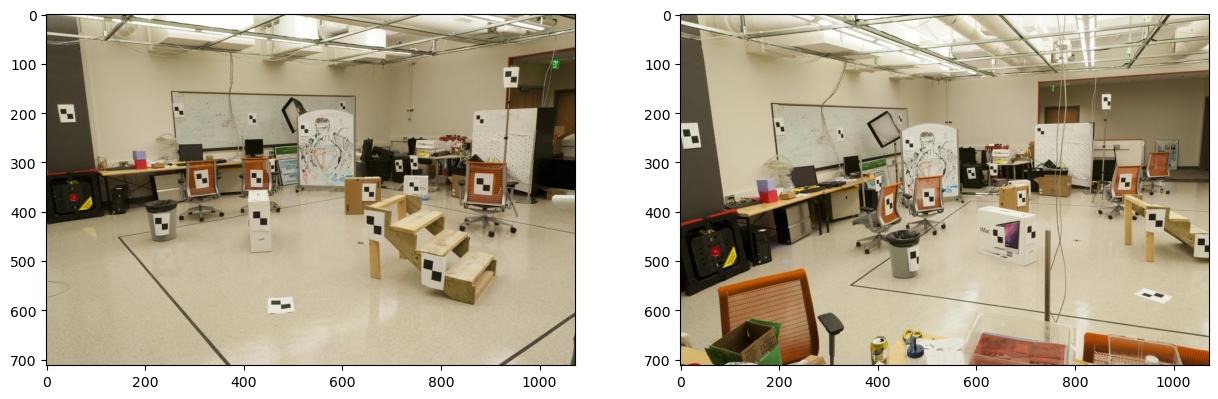

In [2]:
input_dir = Path("D:\Projects\pythonProject\CV\course_resources\ps_3")

img1 = cv2.cvtColor(cv2.imread(str(input_dir / 'pic_a.jpg'), cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(str(input_dir / 'pic_b.jpg'), cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

`loadtxt` works like magic!

In [3]:
pts3d = np.loadtxt(input_dir / 'pts3d.txt')
pts3d_norm = np.loadtxt(input_dir / 'pts3d-norm.txt')
pts2d_a = np.loadtxt(input_dir / 'pts2d-pic_a.txt')
pts2d_b = np.loadtxt(input_dir / 'pts2d-pic_b.txt')
pts2d_a_norm = np.loadtxt(input_dir / 'pts2d-norm-pic_a.txt')

Draw the points on the image

Hint: Use cv2.circle

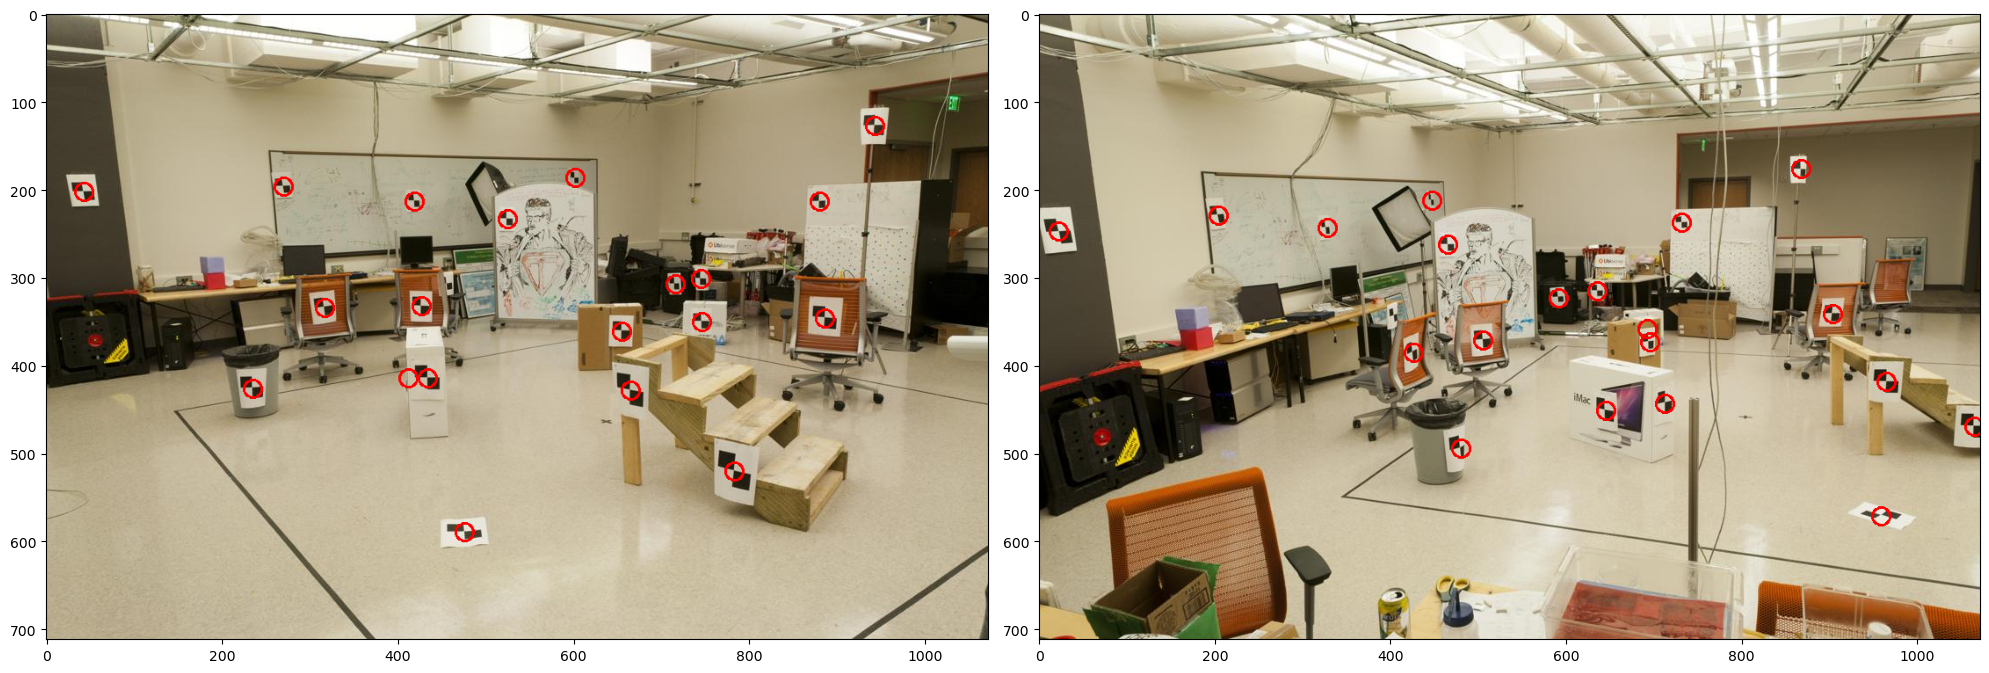

In [4]:
plt.figure(figsize=(20, 10))
for i, (img, pts) in enumerate(zip([img1, img2], [pts2d_a, pts2d_b])):
    img = img.copy()
    ################
    # Your code here
    for pt in pts:
        cv2.circle(img, (int(pt[0]), int(pt[1])), 10, (255, 0, 0), 2)
    ################
    plt.subplot(121 + i)
    plt.imshow(img)
plt.tight_layout()
plt.show()

# Part 1 - Calibration 
The files pts2d-pic_a.txt and pts3d.txt are a list of twenty 2D and 3D points of the image pic_a.jpg. The goal is to compute the projection matrix that goes from world 3D coordinates to 2D image coordinates. Recall that using homogeneous coordinates the equation is:

$$
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix} \cong
\begin{bmatrix}
s * u \\
s * v \\
s
\end{bmatrix} =
\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & m_{1,4} \\
m_{2,1} & m_{2,2} & m_{2,3} & m_{2,4} \\
m_{3,1} & m_{3,2} & m_{3,3} & m_{3,4}
\end{bmatrix}
\begin{bmatrix}
X \\
Y \\
Z \\
1
\end{bmatrix}
$$

Recall you solve for the 3x4 matrix M using either SVD to solve the homogeneous version of the equations or by setting $m_{3,4}$ to 1 and then using the a normal least squares method. Remember that M is only known up to a scale factor.

To make sure that your code is correct, we are going to give you a set of “normalized points” in the files pts2d-norm-pic_a.txt and pts3d-norm.txt. If you solve for M using all the points you should get a matrix that is a scaled equivalent of the following: 

$$ M_\text{normA} = \begin{bmatrix}
-0.4583 & 0.2947 & 0.0139 & -0.0040 \\
0.0509 & 0.0546 & 0.5410 & 0.0524 \\
-0.1090 & -0.1784 & 0.0443 & -0.5968
\end{bmatrix} $$

For example, this matrix will take the last normalized 3D point which is $< 1.2323, 1.4421, 0.4506, 1.0 >$ and will project it to the $< u, v >$ of $< 0.1419, −0.4518 >$ where we converted the homogeneous 2D point $< u_s, v_s, s >$ to its inhomogeneous version by dividing by s (i.e. the real transformed pixel in the image). 

## Part a

Create the **least squares** function that will solve for the 3x4 matrix $M_{normA}$  given the **normalized** 2D and 3D lists, namely pts2d-norm-pic_a.txt and pts3d-norm.txt.

Test it on the normalized 3D points by multiplying those points by your M matrix and comparing the resulting the normalized 2D points to the normalized 2D points given in the file. Remember to divide by the homogeneous value to get an inhomogeneous point. 

You can do the comparison by checking the residual between the predicted location of each test point using your equation and the actual location given by the 2D input data. The residual is just the distance (square root of the sum of squared differences in u and v). 

In [5]:
def euclidean_to_homogeneous(points: np.ndarray) -> np.ndarray:
    """
    Convert euclidean points to homogeneous points, by appending 1 to the end of the points
    :param points: numpy array of shape (N, d) where N is the number of points and d is the dimension of the points
    :return: numpy array of shape (N, d+1)
    """
    ################
    # Your code here
    points = np.hstack((points, np.ones((points.shape[0], 1))))
    ################
    return points


def homogenous_to_euclidean(points: np.ndarray) -> np.ndarray:
    """
    Convert homogeneous points to euclidean points, by dividing the first d-1 elements by the last element
    :param points: numpy array of shape (N, d) where N is the number of points and d is the dimension of the points
    :return: numpy array of shape (N, d-1)
    """
    ################
    # Your code here
    points = points[:, :-1] / points[:, -1:]
    ################
    return points


def project_points(points: np.ndarray, M: np.ndarray) -> np.ndarray:
    """
    Project 3D points to 2D using the projection matrix M
    :param points: numpy array of shape (N, 3) where N is the number of points and 3 is the dimension of the points
    :param M: numpy array of shape (3, 4) representing the projection matrix
    :return: 
    """
    ################
    # Your code here
    projected_points = np.dot(M, euclidean_to_homogeneous(points).T).T
    projected_points = homogenous_to_euclidean(projected_points)
    ################
    return projected_points


def compute_geometric_error(points2d: np.ndarray, points3d: np.ndarray, M) -> float:
    """
    Compute the geometric error between the projected points and the actual points
    :param points2d: numpy array of shape (N, 2) representing the 2D points
    :param points3d: numpy array of shape (N, 3) representing the 3D points
    :param M: numpy array of shape (3, 4) representing the projection/ calibration matrix
    :return: geometric error of the projection of the 3D points on image with the 2D points
    """
    ################
    # Your code here
    projected_points = project_points(points3d, M)
    error = np.sqrt(np.sum((points2d - projected_points) ** 2))
    ################
    return error


def find_M(points2d: np.ndarray, points3d: np.ndarray) -> np.ndarray:
    """
    Calculate the projection matrix M using the least squares method
    :param points2d: numpy array of shape (N, 2) representing the 2D points
    :param points3d: numpy array of shape (N, 3) representing the 3D points
    :return: numpy array of shape (3, 4) representing the projection matrix
    """
    ################
    # Your code here
    A = np.zeros((2 * points2d.shape[0], 11))

    # builds A:
    # ( Xi Yi Zi 1  0  0  0  0 -uiXi -uiYi -uiZi )
    # ( 0  0  0  0  Xi Yi Zi 1 -viXi -viYi -viZi )

    for i in range(points2d.shape[0]):
        A[2 * i, :4] = np.hstack((points3d[i], 1))
        A[2 * i, 8:] = -points2d[i, 0] * points3d[i]
        A[2 * i + 1, 4:8] = np.hstack((points3d[i], 1))
        A[2 * i + 1, 8:] = -points2d[i, 1] * points3d[i]

    # builds b:
    # ( ui )
    # ( vi )

    b = np.hstack(points2d)

    # Solve least squares: 
    #       ||Am - b|| = 0  
    # Close solution by Deriving and finding the minimum:
    #       A^T A m - A^t b = 0
    #       A^T A m = A^t b
    #       m = (A^T A)^-1 A^t b
    ################
    # M = np.linalg.lstsq(A, b)[0]
    M = np.linalg.inv(A.T @ A) @ A.T @ b
    M = np.append(M, 1)
    return M.reshape(3, 4)

In [6]:
M_star = np.array([
    [-0.4583, 0.2947, 0.0139, -0.0040],
    [0.0509, 0.0546, 0.5410, 0.0524],
    [-0.1090, -0.1784, 0.0443, -0.5958]
])

error = compute_geometric_error(pts2d_a_norm, pts3d_norm, M_star)
print('The mean geometric error on the normalized points in scene A using M* is {:.2e}'.format(error))

The mean geometric error on the normalized points in scene A using M* is 1.52e-02


This value should be very low.

In [7]:
M_norm_a = find_M(pts2d_a_norm, pts3d_norm)
error = compute_geometric_error(pts2d_a_norm, pts3d_norm, M_norm_a)
print('The mean geometric error on the normalized points in scene A is {:.2e}'.format(error))

The mean geometric error on the normalized points in scene A is 1.30e-02


What is your error relative to the ideal?

The error is a little lower.

In [8]:
#######################################
# Compare the matrix you computed to M*
diff = np.sqrt(np.sum((M_star - M_norm_a) ** 2))
print(f"Difference is {diff:.2f}")
#######################################

Difference is 2.67


In [139]:
scaled_M = M_norm_a * (M_star[2, 3] / M_norm_a[2, 3])
diff_scaled = np.sqrt(np.sum((M_star - scaled_M) ** 2))
print(f"Difference is {diff_scaled:.2f}")

Difference is 1.37e-03


How similar are the two matrices?

Different, can be because of scale

## Part b

Now you are ready to calibrate the camera. Using the 3D and 2D point lists for the image, we’re going to compute the camera projection matrix. To understand the effects of over constraining the system, you’re going to try using sets of 8, 12 and 16 points and then look at the residuals. To debug your code you can use the normalized set from above but for the actual question you’ll need to use: **pts2d-pic_b.txt and pts3d.txt**

For the three point set sizes $k$ of 8, 12, and 16, repeat 10 times:
- Randomly choose k points from the 2D list and their corresponding points in the 3D list.
- Compute the projection matrix M on the chosen points.
- Pick 4 points not in your set of k and compute the average residual error.
- Save the M that gives the lowest residual error.

In [10]:
best_M = None
best_error = np.inf

for k in [8, 12, 16]:
    print(f'k={k}')
    for i in range(10):
        # sample train and test points
        sample_indices = np.random.choice(pts2d_b.shape[0], k + 4, replace=False)
        sample2d_train = pts2d_b[sample_indices][:-4]
        sample2d_test = pts2d_b[sample_indices][-4:]
        sample3d_train = pts3d[sample_indices][:-4]
        sample3d_test = pts3d[sample_indices][-4:]
        M = find_M(sample2d_train, sample3d_train)
        train_error = compute_geometric_error(sample2d_train, sample3d_train, M)
        test_error = compute_geometric_error(sample2d_test, sample3d_test, M)
        print(f'i={i} train_error={train_error:.2f} test_error={test_error:.2f}', end='')
        if test_error < best_error:
            best_error = test_error
            best_M = M
            print(' New Best!', end='')
        print()

k=8
i=0 train_error=1.39 test_error=3.92 New Best!
i=1 train_error=0.70 test_error=2.09 New Best!
i=2 train_error=1.95 test_error=2.70
i=3 train_error=1.02 test_error=6.18
i=4 train_error=1.30 test_error=2.44
i=5 train_error=1.76 test_error=8.58
i=6 train_error=1.70 test_error=3.86
i=7 train_error=1.27 test_error=3.31
i=8 train_error=1.62 test_error=4.48
i=9 train_error=1.43 test_error=39.68
k=12
i=0 train_error=2.49 test_error=3.15
i=1 train_error=2.84 test_error=3.45
i=2 train_error=2.61 test_error=3.38
i=3 train_error=1.83 test_error=2.70
i=4 train_error=2.82 test_error=4.71
i=5 train_error=3.15 test_error=4.49
i=6 train_error=2.57 test_error=3.10
i=7 train_error=2.11 test_error=2.44
i=8 train_error=2.54 test_error=1.76 New Best!
i=9 train_error=2.66 test_error=2.45
k=16
i=0 train_error=2.99 test_error=3.13
i=1 train_error=2.83 test_error=3.16
i=2 train_error=3.52 test_error=1.98
i=3 train_error=3.19 test_error=4.03
i=4 train_error=3.61 test_error=2.16
i=5 train_error=3.35 test_erro

In [11]:
print(f'The lowest error achieved is {best_error:.2f}')
display(best_M)

The lowest error achieved is 1.34


array([[-2.0450e+00,  1.1828e+00,  3.9988e-01,  2.4436e+02],
       [-4.5588e-01, -3.0286e-01,  2.1461e+00,  1.6592e+02],
       [-2.2436e-03, -1.0976e-03,  5.6509e-04,  1.0000e+00]])

### Part c

Finally we can solve for the camera center in the world. Let us define M as being made up of a 3x3 we’ll call Q and a 4th column will call $m_4
$:

$$M = [\mathbf{Q}|\mathbf{m_4}]$$

From class we said that the center of the camera $C$ could be found by:

$$C= - Q^{-1} \mathbf{m_4}$$

To debug your code: If you use you the normalized 3D points to get the $M_{normA}$ given above you would get a camera center of:

$$C_{normA} = < -1.5125, -2.3515, 0.2826 >$$
Given the best M from the last part, compute $C$.

In [12]:
def find_camera_center(M: np.ndarray) -> np.ndarray:
    ################
    # Your code here
    Q = M[:, :-1]
    m = M[:, -1:]
    C = -np.linalg.inv(Q) @ m
    ################
    return C

Let's test our code on the normalized points:

In [13]:
find_camera_center(M_norm_a)

array([[-1.5126],
       [-2.3517],
       [ 0.2827]])

Is it close to the $C_{normA}$?

Yes

In [14]:
find_camera_center(best_M)

array([[303.103 ],
       [307.1789],
       [ 30.4233]])

This is the approximate location of camera b in real world coordinates.

# Part 2 - Fundamental Matrix Estimation

We now wish to estimate the mapping of points in one image to lines in another by means of the fundamental matrix. This will require you to use similar methods to those in question 1. We will make use of the corresponding point locations listed in **pts2d-pic_a.txt and pts2d-pic_b.txt**.

Recall that the definition of the Fundamental Matrix is:

$$
\begin{bmatrix} u' & v' & 1 \end{bmatrix}
\begin{bmatrix}
f_{1,1} & f_{1,2} & f_{1,3} \\
f_{2,1} & f_{2,2} & f_{2,3} \\
f_{3,1} & f_{3,2} & f_{3,3}
\end{bmatrix}
\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = 0
$$

Given corresponding points you get one equation per point pair. With 8 or more points you can solve this. With more points (such as the 20 in the files) you solve using the the same least squares method as in question 1 above.

## Part a

Create the least squares function that will solve for the 3x3 matrix $\hat{F}$ that satisfies the epipolar constraints defined by the sets of corresponding points. Solve this function to create your least squares estimate of the 3x3 transform $\hat{F}$.

In [15]:
def find_F_ls(points2d_imga, points2d_imgb) -> np.ndarray:
    ################
    # Your code here
    # transform to A f - b , while setting f9 = 1
    # solving for f: u'u f1 + uv' f2 + u f3 + u'v f4 + v'v f5 + v' f6 + u' f7 + v' f8 + 1 = 0
    # Thus, a row in A = (u^2 uv u uv v^2 v u v) 
    A = np.zeros((points2d_imga.shape[0], 8))
    for i in range(points2d_imga.shape[0]):
        pa = points2d_imga[i]
        pb = points2d_imgb[i]
        A[i] = np.array([pa[0] * pb[0], pa[0] * pb[1], pa[0], pa[1] * pb[0], pa[1] * pb[1], pa[1], pb[0], pb[1]])

    b = np.ones(shape=(points2d_imga.shape[0], 1), dtype=A.dtype) * -1

    F = np.linalg.inv(A.T @ A) @ A.T @ b
    F = np.append(F, 1)
    ################
    return F.reshape(3, 3)

In [16]:
F = find_F_ls(pts2d_a, pts2d_b)
display(F)

array([[-6.6068e-07,  8.8267e-06, -9.0854e-04],
       [ 7.9064e-06,  1.2186e-06, -2.6420e-02],
       [-1.8848e-03,  1.7228e-02,  1.0000e+00]])

Compute the residuals $\|x'Fx\|$

In [17]:
################
# Your code here
print(pts2d_a.shape, F.shape, pts2d_b.shape)
residual = np.sum(euclidean_to_homogeneous(pts2d_a) @ F @ euclidean_to_homogeneous(pts2d_b).T)
################
print('The mean residual of the fundamental matrix is {:.2e}'.format(residual))

(20, 2) (3, 3) (20, 2)
The mean residual of the fundamental matrix is -3.49e+01


## Part b

The linear squares estimate of $\hat{F}$ is full rank; however, the fundamental matrix is a rank 2 matrix. As such we must reduce its rank. 
In order to do this we can decompose $\hat{F}$ using singular value decomposition into the matrices $U \Sigma V^T = \hat{F}$. 
We can then estimate a rank 2 matrix by setting the smallest singular value in $\Sigma$ to zero thus generating $\Sigma'$. 
The fundamental matrix is then easily calculated as $F=U \Sigma' V^T$. Use the SVD function to do, well, the SVD. Duh.

In [18]:
def turn_singular(F) -> np.ndarray:
    ################
    # Your code here
    U, S, V = np.linalg.svd(F)
    S[np.argmin(S)] = 0
    # sigma = S * np.eye(len(S))
    sigma = np.diag(S)
    F = U @ sigma @ V
    ################
    return F

In [19]:
F_sing = turn_singular(F)
display(F_sing)

array([[-5.3588e-07,  8.8382e-06, -9.0854e-04],
       [ 7.8997e-06,  1.2180e-06, -2.6420e-02],
       [-1.8848e-03,  1.7228e-02,  1.0000e+00]])

Complete the following prints

In [20]:
print('The singular values of the linear estimate of F are: {}'.format(np.linalg.svd(F)[1]))
print('The singular values of the new F are: {}'.format(np.linalg.svd(F_sing)[1]))
print('The absolute difference between the matrices is {:.2e}'.format(np.sum((F - F_sing) ** 2)))

The singular values of the linear estimate of F are: [1.0005e+00 4.5873e-04 1.2550e-07]
The singular values of the new F are: [1.0005e+00 4.5873e-04 5.9280e-20]
The absolute difference between the matrices is 1.57e-14


## Part c

Now you can use your matrix $F$ to estimate an epipolar line $l_b$ in image ‘b’ corresponding to point $p_a$ in image ‘a’: $l_b = F p_a$.

Similarly, epipolar lines in image a corresponding to points in image b are related by the transpose of $F$.

**Note: These relations might be reversed depending on how you computed $F$.**

Draw these epipolar lines. Below is one way; the key is to be able to take the projective geometry form of the line and draw it in the image:

- The resulting lines $l_i$ defined in homogeneous coordinates can not be drawn directly using standard line functions, which take as input two points. In order to use such functions, we can find the intersection of a given line $l_i$ with the image boundaries.
- If we define $l_L$ to be the line corresponding to the left hand side of the image and $l_R$ to be the line corresponding to the right hand side of the image, we can find the points $P_{u,L} = l_i \times i_L$ and $P_{u,R} = l_i \times i_R$. We can now plot the line running through the points $P_{u,L}$, $P_{u,R}$.
- However, we must first have the equations for $l_L$ and $l_R$. Making use of the point-line duality, we know, e.g., $l_L = P_{UL} \times P_{BL}$. Where $P_{UL}$ is the point defining the upper left-hand corner of the image and $P_{BL}$ is the bottom left-hand corner of the image.
- An example of such an image is:

![epipolar lines image a](images/epipolar_lines_gt.png)

Draw the epipolar lines and the points to make sure they connect. Pay close attention to how you transpose F.

In [21]:
def draw_epipolar_lines(image, points2d_a, points2d_b, F) -> np.ndarray:
    """
    Draw the epipolar lines on the image
    :param image: numpy array of shape (H, W, 3) representing the image
    :param points2d_a: numpy array of shape (N, 2) representing the 2D points in the given image
    :param points2d_b: numpy array of shape (N, 2) representing the 2D points in the other image (to draw the epipolar lines)
    :param F: The fundamental matrix
    :return: numpy array of shape (H, W, 3) representing the image with the epipolar lines drawn
    """
    ################
    # Your code here
    image = image.copy()
    lines = (F
             @ euclidean_to_homogeneous(points2d_b).T).T
    left_side = np.array([1, 0, 0]).reshape(1, -1)  # x=0 can be calculated by the cross: (0, 0, 1), (0, hight, 1).
    right_side = np.array([1, 0, -image.shape[1]]).reshape(1,
                                                           -1)  # x - w = 0 can be calculated by the cross: (width, hight, 1), (width, 0, 1)

    # find the points by crossing the lines:
    points_left = np.cross(lines, left_side, axis=1)
    points_right = np.cross(lines, right_side, axis=1)
    points_right = homogenous_to_euclidean(points_right)
    points_left = homogenous_to_euclidean(points_left)

    # draw the lines and points on the image
    for i in range(points2d_a.shape[0]):
        cv2.circle(image, (int(points2d_a[i][0]), int(points2d_a[i][1])), 10, (255, 0, 0), 2)
        try:
            cv2.line(image, (int(points_left[i][0]), int(points_left[i][1])),
                     (int(points_right[i][0]), int(points_right[i][1])), (0, 255, 0), 2)
        except ValueError:
            print(i)
            pass  # the lines are parallel to the image
    ################
    return image

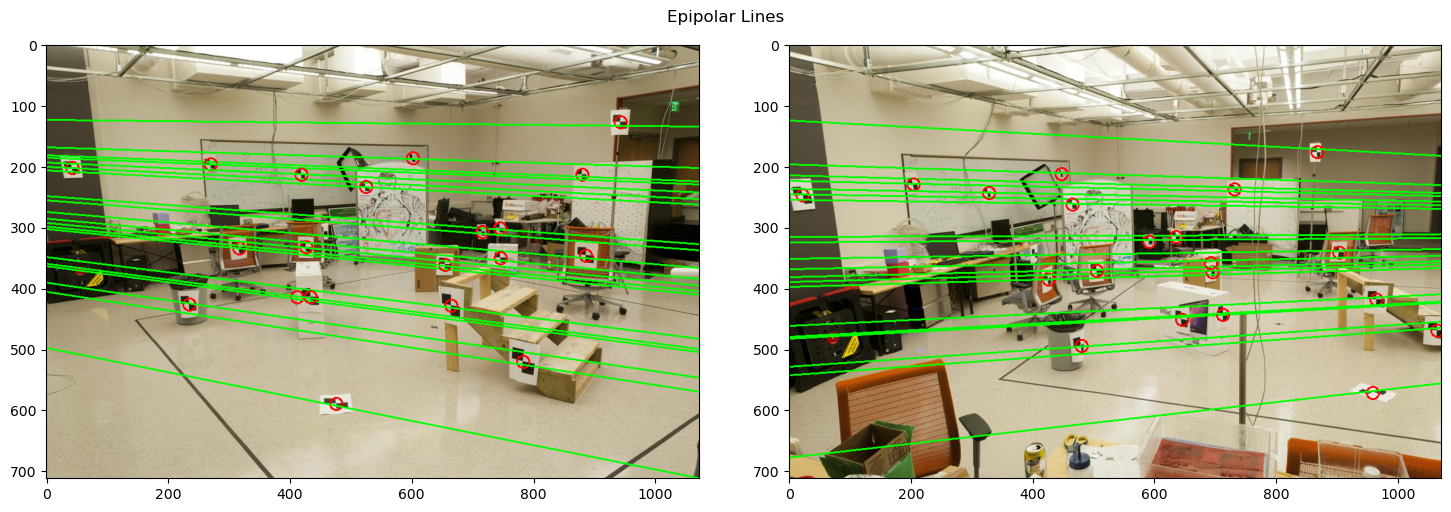

In [22]:
plt.figure(figsize=(15, 5))
plt.suptitle('Epipolar Lines')
plt.subplot(121)
plt.imshow(draw_epipolar_lines(img1, pts2d_a, pts2d_b, F_sing))
plt.subplot(122)
plt.imshow(draw_epipolar_lines(img2, pts2d_b, pts2d_a, F_sing.T))
plt.tight_layout()
plt.show()

### Question

Look at the result you got for image a, how do they compare to the ground truth? Discuss with your mentor.

Hint: Look at the bottom and top lines.

![epipolar lines image a](images/epipolar_lines_gt.png)

# EXTRA CREDIT PROBLEMS (2-d and 2-e)


## Part d

If you look at the results of the last section the epipolar lines are close, but not perfect. The problem is that the offset and scale of the points is large and biased compared to some of the constants. To fix this, we are going to normalize the points.

In the 2D case this normalization is really easy. We want to construct transformations that make the mean of the points zero and, optionally, scale them so that their magnitude is about 1.0 or some other not too large number:

$$
\begin{bmatrix}
u' \\
v' \\
1
\end{bmatrix} =
\begin{bmatrix}
s & 0 & 0 \\
0 & s & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
1 & 0 & -c_u \\
0 & 1 & -c_v \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
$$

The transform matrix $T$ is the product of the scale and offset matrices. The $c_u, c_v$ is just the mean. To compute a scale $s$ you could estimate the standard deviation after subtracting the means. Or you could find the maximum absolute value. Then the scale factor $s$ would be the reciprocal of whatever estimate of the scale you are using.

Create two matrices $T_a$ and $T_b$ for the set of points defined in the files **pts2d-pic_a.txt and pts2d-pic_b.txt** respectively. 
Use these matrices to transform the two sets of points. 
Then use these normalized points to create a new Fundamental matrix $\hat{F}$. Compute it as above including making the smaller singular value zero.

In [136]:
def normalize_points(points2d: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Normalize the 2D points by translating the mean to the origin and scaling the points
    :param points2d: numpy array of shape (N, 2) representing the 2D points
    :return: tuple of numpy arrays representing:
             1) Normalized points
             2) Transformation matrix
    """
    cu, cv = np.mean(points2d, axis=0)
    # std = np.max(np.abs(points2d - np.array([cu, cv])), axis=0)
    # std = np.std(points2d - np.array([cu, cv]), axis=0)
    std = np.std(points2d - np.array([cu, cv]))
    

    offset_matrix = np.eye(3)
    offset_matrix[0, 2] = -cu
    offset_matrix[1, 2] = -cv

    scale_matrix = np.diag([1/std, 1/std, 1])

    T = scale_matrix @ offset_matrix

    points_normalized = T @ euclidean_to_homogeneous(points2d).T

    # Convert back to euclidean
    points_normalized = homogenous_to_euclidean(points_normalized.T)

    return points_normalized, T

In [137]:
pts2d_a_norm, T_a = normalize_points(pts2d_a)
pts2d_b_norm, T_b = normalize_points(pts2d_b)

print('T_a')
display(T_a)
print('T_b')
display(T_b)

F_norm = find_F_ls(pts2d_a_norm, pts2d_b_norm)
print('F_norm')
display(F_norm)

F_norm_sing = turn_singular(F_norm)
print('Singular F_norm')
display(F_norm_sing)

print('The singular values of the linear estimate of F_norm are: {}'.format(np.linalg.svd(F_norm)[1]))
print('The singular values of the new F_norm are: {}'.format(np.linalg.svd(F_norm_sing)[1]))
print('The absolute difference between the matrices is {:.2e}'.format(np.sum((F_norm - F_norm_sing) ** 2)))

T_a


array([[ 0.0054,  0.    , -2.997 ],
       [ 0.    ,  0.0054, -1.7458],
       [ 0.    ,  0.    ,  1.    ]])

T_b


array([[ 0.0051,  0.    , -3.1209],
       [ 0.    ,  0.0051, -1.7555],
       [ 0.    ,  0.    ,  1.    ]])

F_norm


array([[  0.2108,  -2.2331,  -3.1993],
       [ -3.5637,   0.6807,  38.4751],
       [ -0.5864, -43.3215,   1.    ]])

Singular F_norm


array([[  0.2704,  -2.2338,  -3.1938],
       [ -3.5587,   0.6806,  38.4755],
       [ -0.5894, -43.3215,   0.9997]])

The singular values of the linear estimate of F_norm are: [43.3916 38.7817  0.0602]
The singular values of the new F_norm are: [4.3392e+01 3.8782e+01 7.9353e-16]
The absolute difference between the matrices is 3.62e-03


## Part e

Finally you can create a better $F$ by: $F = T_b^T \hat{F} T_a$

Using this new  redraw the epipolar lines of 2-c. They should be better.

Rescaled F


array([[ 7.3381e-06, -6.0611e-05, -6.2407e-04],
       [-9.6561e-05,  1.8467e-05,  2.5944e-01],
       [ 2.4356e-02, -1.9137e-01, -5.2350e+00]])

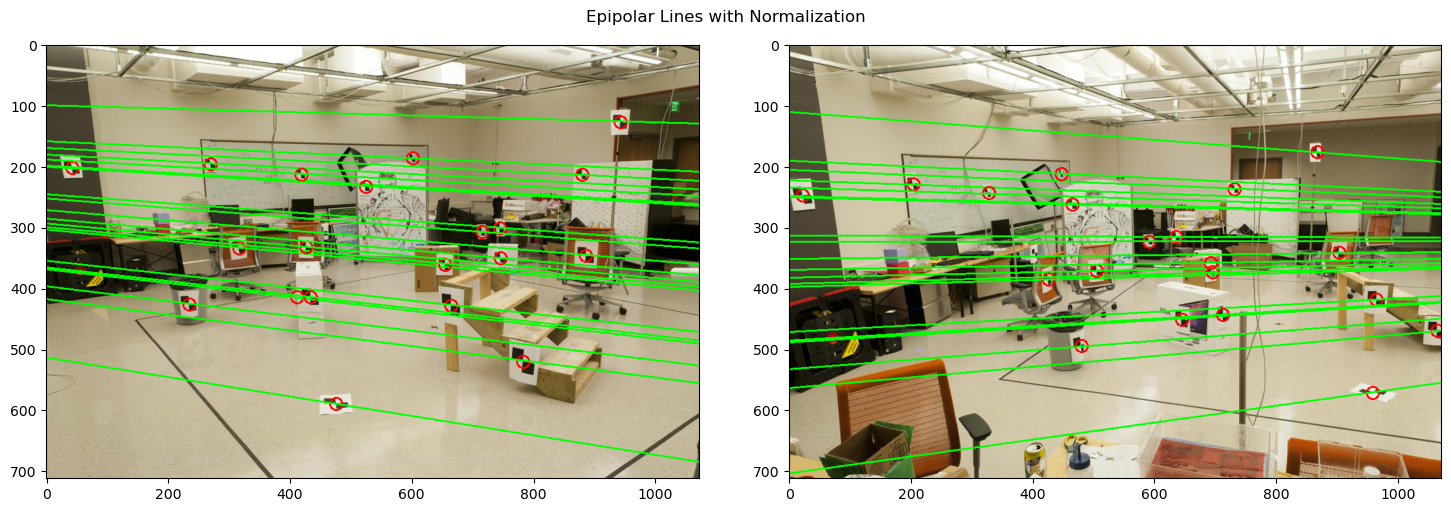

In [138]:
F_rescale = T_a.T @ F_norm_sing @ T_b
print('Rescaled F')
display(F_rescale)

plt.figure(figsize=(15, 5))
plt.suptitle('Epipolar Lines with Normalization')
plt.subplot(121)
plt.imshow(draw_epipolar_lines(img1, pts2d_a, pts2d_b, F_rescale))
plt.subplot(122)
plt.imshow(draw_epipolar_lines(img2, pts2d_b, pts2d_a, F_rescale.T))
plt.tight_layout()
plt.show()

### Question

Again, look at the new result for, how do they compare to the ground truth? Discuss with your mentor.

![epipolar lines image a](images/epipolar_lines_gt.png)